# Notebook to process Kaggle's Titanic dataset

This notebook uses the dataset from Kaggle's Titanic Comptetition to train a logistic regression and provides results with the test dataset
https://www.kaggle.com/c/titanic

author: drublackberry (github)

## Configuration
User configuration parameters

In [1]:
train_size = 80 # % of the training set used for training
N_MonteCarlo = 50 # number of runs for the monte-carlo analysis

## Data pre-processing and exploratory data analysis
Gather the train dataset, convert feature to numerical values and plot the values in stacked histograms to get a feeling of the importance of the features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display
    
# Load into CSV
myRawTrainDf = pd.read_csv('train.csv', index_col=0)
myRawTestDf = pd.read_csv('test.csv', index_col=0)

# Add survived column before merging
myRawTestDf['Survived'] = np.nan
myRawTestDf = myRawTestDf[myRawTrainDf.columns]

# Merge
myRawDf = myRawTrainDf.append(myRawTestDf)

## Feature exploration
This chapter will explore the weight of the features wrt survival rate and will explore the possibilities of 

### Features on the name
The name itself can contain some features of interest, if we explore it closely we can see that the pattern of ', 'and '.' allows us to retrieve the title and the surname.

In [3]:
# Inspect the names to see if something can be done
myRawDf['Name'].head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Let's create two extra columns with the title and the surname to be used as features.

In [4]:
import re

def getTitle (aName):
    '''Finds the title in the name'''
    myPosStart = aName.find(',')
    myPosEnd = aName.find('.')
    return re.sub('[^A-Za-z0-9]+', '', aName[myPosStart:myPosEnd])
def getSurname (aName):
    '''Finds the title in the name'''
    myPos = aName.find(',')
    return re.sub('[^A-Za-z0-9]+', '', aName[:myPos])

myInDf = myRawDf.copy()
myInDf['Title'] = [getTitle(x) for x in myInDf['Name']]
myInDf['Surname'] = [getSurname(x) for x in myInDf['Name']]

# Get a sample
myInDf.head(3).append(myInDf.tail(3))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,Saether
1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,Ware
1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master,Peter


In order to be able to plot and perform regressions (if needed) one can assign a number to each string for each feature.

In [5]:
def assignNumericalType (aSeries):
    '''Assigns a numerical type to string values'''
    val = aSeries.unique()
    myDict = {val[x]:x for x in range(len(val))}
    myDict[np.nan] = np.nan # Ensure nan stays nan
    aOut = [myDict[x] for x in aSeries]
    return aOut

# Convert strings to numerical type
for myCol in myInDf.columns:
    if type(myInDf[myCol].dropna().iloc[0])==str:
        myInDf[myCol] = assignNumericalType(myInDf[myCol])
        
# Get a sample
myInDf.head(3).append(myInDf.tail(3))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
1,0.0,3,0,0,22.0,1,0,0,7.2500,NaN,0.0,0,0
2,1.0,1,1,1,38.0,1,0,1,71.2833,1.0,1.0,1,1
3,1.0,3,2,1,26.0,0,0,2,7.9250,NaN,0.0,2,2
1307,NaN,3,1304,0,38.5,0,0,927,7.2500,NaN,0.0,0,874
1308,NaN,3,1305,0,NaN,0,0,928,8.0500,NaN,0.0,0,818
1309,NaN,3,1306,0,NaN,1,1,119,22.3583,NaN,1.0,3,117


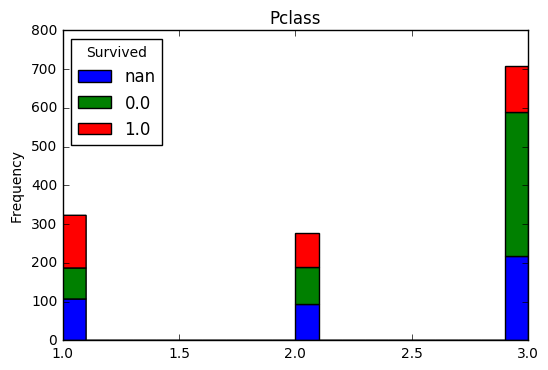

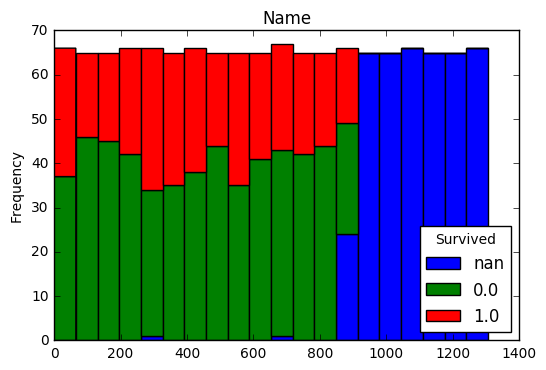

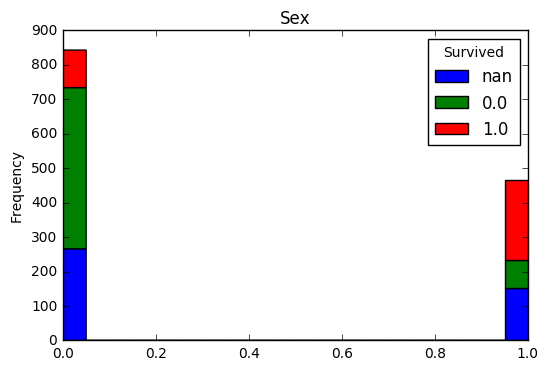

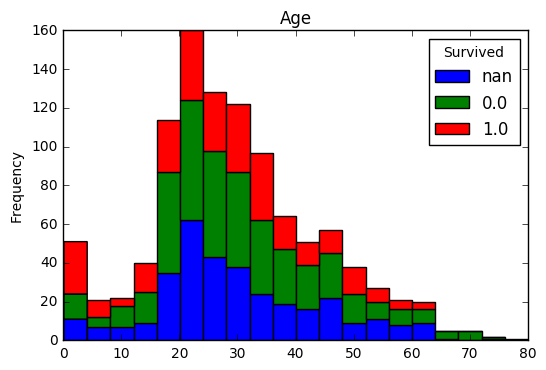

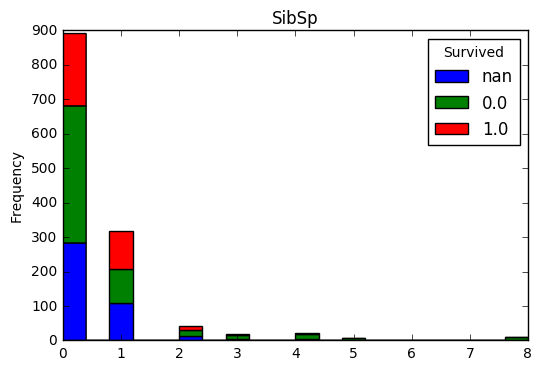

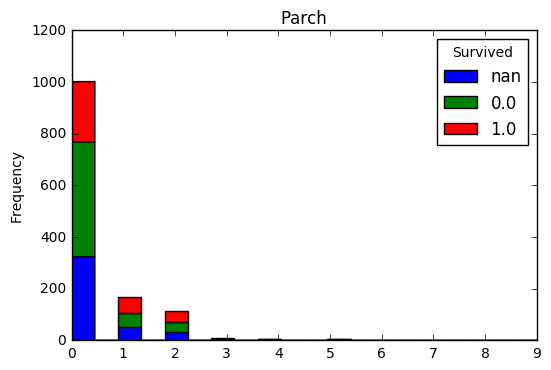

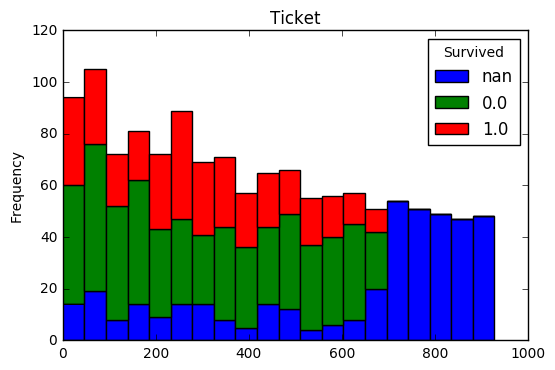

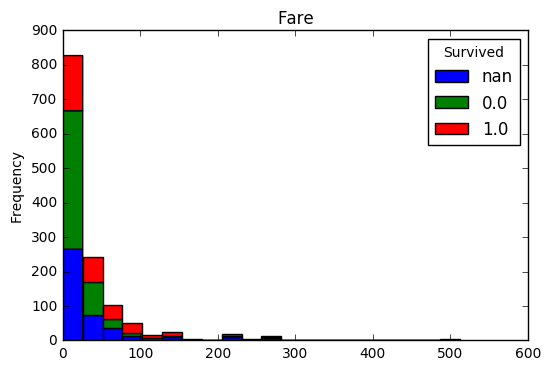

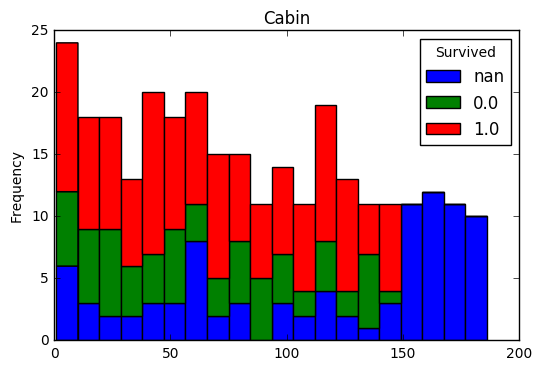

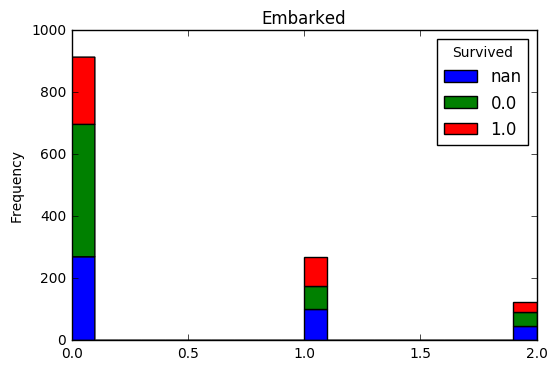

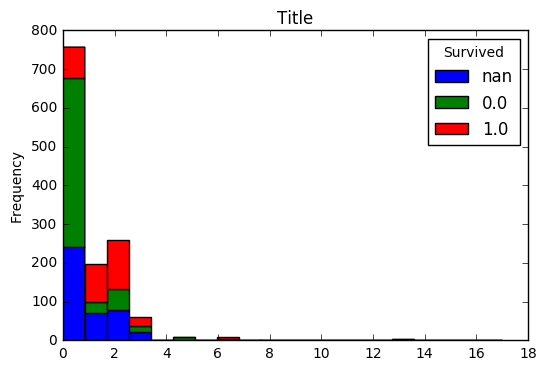

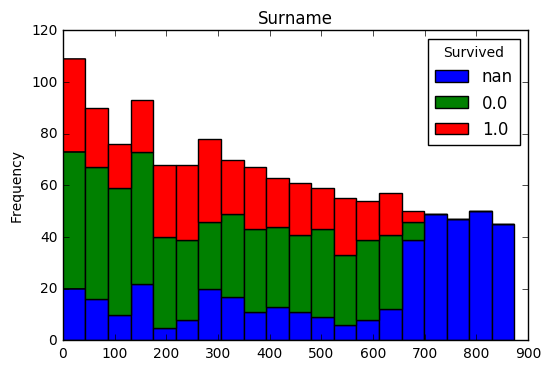

In [6]:
# Exploratory data analysis
for myFeature in myInDf.columns:
    if myFeature != 'Survived' and (len(myInDf[myFeature]) > len(myInDf[myFeature].unique())):
        myInDf.pivot(columns='Survived', values=myFeature).plot(kind='hist', stacked=True, bins=20)
        plt.title(myFeature)
        plt.show()

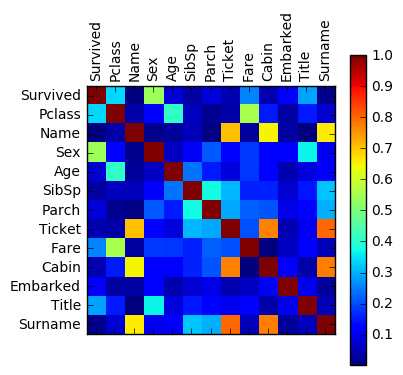

In [7]:
# Do a correlation plot
cax = plt.matshow(myInDf.corr().abs())
plt.colorbar(cax)
plt.xticks(range(len(myInDf.columns)), myInDf.columns, rotation='vertical')
plt.yticks(range(len(myInDf.columns)), myInDf.columns, rotation='horizontal')
plt.show()

## Conclusions of the exploratory data analysis

* Passenger on the age 20-40 are more likely to die.
* Babies and infants are more likely to survive.
* Most passenger where in the range 20-40 with children (i.e. families).
* Older people is more likely to survive
* Lower fares are more likely to die
* People with more than 3 siblings is likely to die
* Travelling with no siblings meant a higher change of survival
* People not related to children are more likely to die
* There is a clear dependence on passenger class
* Males are more likely to die
* There is a certain dependence on the cabin, port and ticket
* There is high correlation of hte survival with sex, pclass and . Weaker correlations with parch and embarked.
* Title is a strong feature for survival

## Missing data
A part of the dataset is missing, how many missing values do we have in the training set per feature?

In [8]:
myMind = pd.MultiIndex.from_product([['Training', 'Test',],['Missing', 'Total']])
myMissingDf = pd.DataFrame(columns=myMind, index=myInDf.columns)
myMissingDf['Test', 'Missing'] = myInDf[myInDf['Survived'].isnull()].isnull().sum()
myMissingDf['Test', 'Total'] = myInDf[myInDf['Survived'].isnull()].isnull().count()
myMissingDf['Training', 'Missing'] = myInDf[myInDf['Survived'].notnull()].isnull().sum()
myMissingDf['Training', 'Total'] = myInDf[myInDf['Survived'].notnull()].isnull().count()
myMissingDf

Training          Test      
          Missing Total Missing Total
Survived        0   891     418   418
Pclass          0   891       0   418
Name            0   891       0   418
Sex             0   891       0   418
Age           177   891      86   418
SibSp           0   891       0   418
Parch           0   891       0   418
Ticket          0   891       0   418
Fare            0   891       1   418
Cabin         687   891     327   418
Embarked        2   891       0   418
Title           0   891       0   418
Surname         0   891       0   418

Given the results one can conclude that
* The age is missing for a number of passengers but it is still a usable feature given the amount of it that is missing
* The cabin is missing for large part of the dataset, if used as feature it will have little weight
* Two passenger are missing the port where they embarked in the training set, the feature should be still usable
* One passenger is missing the fare in the test test

The age feature is specially interesting given the high correlation with the survival

### Predicting age
Age is a key feature that is missing in a considerable part of the dataset, however, the age can be infered from other features. The predicted age can be used to feed the decision tree.

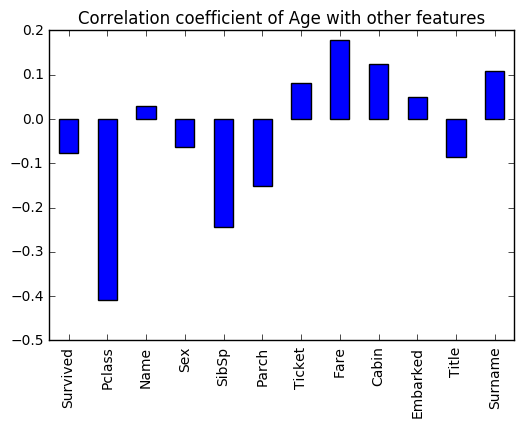

In [9]:
myInDf.corr()[[x for x in myInDf.columns if x != 'Age']].loc['Age'].plot(kind='bar')
plt.title('Correlation coefficient of Age with other features')
plt.show()

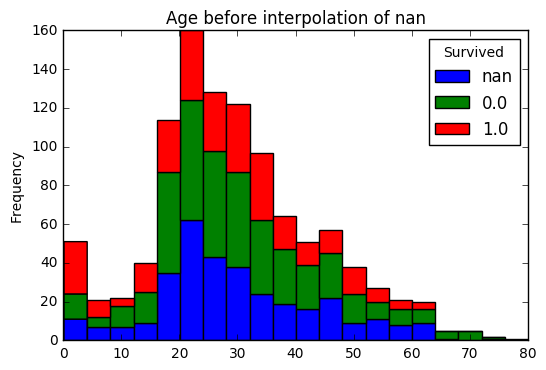

In [10]:
# Recall the distribution of the age
myInDf.pivot(columns='Survived', values='Age').plot(kind='hist', stacked=True, bins=20)
plt.title('Age before interpolation of nan')
plt.show()

In [11]:
# Predict the age with a linear regression
from sklearn import linear_model
from sklearn.preprocessing import normalize

def predictValueByLinearRegression (aInDf, aFeatureToUse, aFeatureToPredict):
    aFeatureToUse.append(aFeatureToPredict)
    myDf = aInDf[aFeatureToUse]
    # Train
    myX = myDf.dropna()[[x for x in myDf.columns if x != aFeatureToPredict]]
    myY = myDf.dropna()[aFeatureToPredict]
    myLR = linear_model.LinearRegression()
    myLR.fit(myX, myY)
    # Predict
    myX = myDf[myDf[aFeatureToPredict].isnull()][[x for x in myDf.columns if x != aFeatureToPredict]]
    return myLR.predict(myX)

In [12]:
# Assign
myInDf.loc[myInDf.isnull()['Age'], 'Age'] = predictValueByLinearRegression(myInDf, ['Sex', 'SibSp', 'Parch', 'Fare', 'Title'], 'Age')

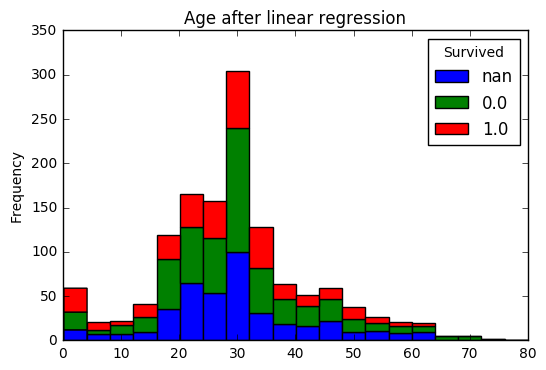

In [13]:
# Check the histogram again to see the distribution
myInDf.pivot(columns='Survived', values='Age').plot(kind='hist', stacked=True, bins=20)
plt.title('Age after linear regression')
plt.show()

### Missing embarked values
There are two values with nan for the embarked. Embarked is a feature that holds a certain correlation with the survival rate. It should be better to keep it.
Let's work on the raw data to see the alphanumerical values

In [14]:
myRawDf[myRawDf['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Both of them where at Cabin B28, on which port did the passengers at these cabin also board? Also it is OK to assume that the tickets were sold in order?

In [15]:
# Get passengers with similar tickets
myRawDf[myRawDf['Ticket'].map(lambda x: '1135' in x or '1136' in x)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
253,0.0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
330,1.0,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
352,0.0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S
357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
524,1.0,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C


One can see that a number of passenger with similar fare price, cabin on the same section and ticket number close enough to the missing ones embarked in 'C'. Let's assume that's their port of origin

In [16]:
# Assign a numerical value
myInDf.loc[myInDf['Embarked'].isnull(), 'Embarked'] = myInDf.loc[55]['Embarked']
# Check
myInDf.loc[[62,830]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
62,1.0,1,61,1,38.0,0,0,60,80.0,13.0,1.0,2,59
830,1.0,1,829,1,62.0,0,0,60,80.0,13.0,1.0,1,629


### Missing fare on test set
One passenger has a missing fare on the test set

In [17]:
myRawDf[myRawDf['Fare'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Let's look at how the fare correlates with the pclass, sex, age and embarcation port.

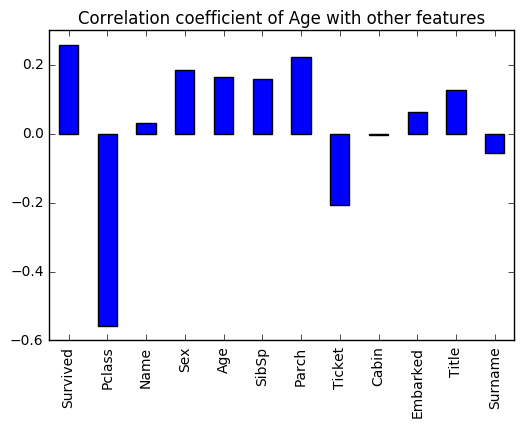

In [18]:
myInDf.corr()[[x for x in myInDf.columns if x != 'Fare']].loc['Fare'].plot(kind='bar')
plt.title('Correlation coefficient of Age with other features')
plt.show()

In [19]:
# Run a linear regression with the features that are most correlated
myInDf.loc[myInDf['Fare'].isnull(), 'Fare'] = predictValueByLinearRegression(myInDf, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title'], 'Fare')

In [20]:
# Check the final 
myInDf.loc[1044]

Survived            NaN
Pclass         3.000000
Name        1041.000000
Sex            0.000000
Age           60.500000
SibSp          0.000000
Parch          0.000000
Ticket       778.000000
Fare           2.782652
Cabin               NaN
Embarked       0.000000
Title          0.000000
Surname      757.000000
Name: 1044, dtype: float64

### Final check
Is there any missing data left in our training set?

In [21]:
myInDf.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
Title          0
Surname        0
dtype: int64

The 'Cabin' feature is largely missing and difficult to be infered from other features, for the moment then let's just discard it.

# Classification using decision trees

In [22]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
    
def splitDataset (aDf, aFrac):
    '''Splits a Df in a training and a validation dataset randomly'''
    aTrainDf = aDf.sample(frac=aFrac/100.)
    myValInd = [ind for ind in aDf.index if ind not in aTrainDf.index]
    aValDf = aDf.loc[myValInd]
    # Create X and Y datasets
    aXtrain = aTrainDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYtrain = aTrainDf['Survived']
    aXval = aValDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYval = aValDf['Survived']
    return aXtrain, aYtrain, aXval, aYval

def assessPerformance (aX, aY, aClf):
    '''Prints the performance of a certain machine learning algorithm'''
    myYpred = aClf.predict(aX)
    aPrecision = precision_score(aY, myYpred)
    aRecall = recall_score(aY, myYpred)
    aF1score = f1_score(aY, myYpred)
    return aPrecision, aRecall, aF1score

def trainPredictAndAnalyzeDecisionTree (aDf, aDepth=None, draw=False):
    # Build a decision tree classifier
    myXtrain, myYtrain, myXval, myYval = splitDataset (aDf, train_size)
    myClf = tree.DecisionTreeClassifier(max_depth=aDepth)
    myClf = myClf.fit(myXtrain, myYtrain)
    aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain, myClf)
    aValPrecision, aValRecall, aValF1 = assessPerformance(myXval, myYval, myClf)
    if draw:
        # Draw the decision tree
        myDotData = tree.export_graphviz(myClf, feature_names=myXtrain.columns, out_file='tree.dot' )
        (myGraph,) = pydot.graph_from_dot_file('tree.dot')
        myPlt = Image(myGraph.create_png())
        myGraph.write_png('tree.png')
        display(myPlt)
    return aTrainPrecision, aTrainRecall, aTrainF1, aValPrecision, aValRecall, aValF1
   
def runMonteCarlo (aDf, aF, *args):
    myPerfDf = pd.DataFrame(columns=['Train Precision', 'Train Recall', 'Train F1', 'Val Precision', 'Val Recall', 'Val F1'])
    for i in range(N_MonteCarlo):
        myPerfDf.loc[i] = aF(aDf, *args)
    return myPerfDf

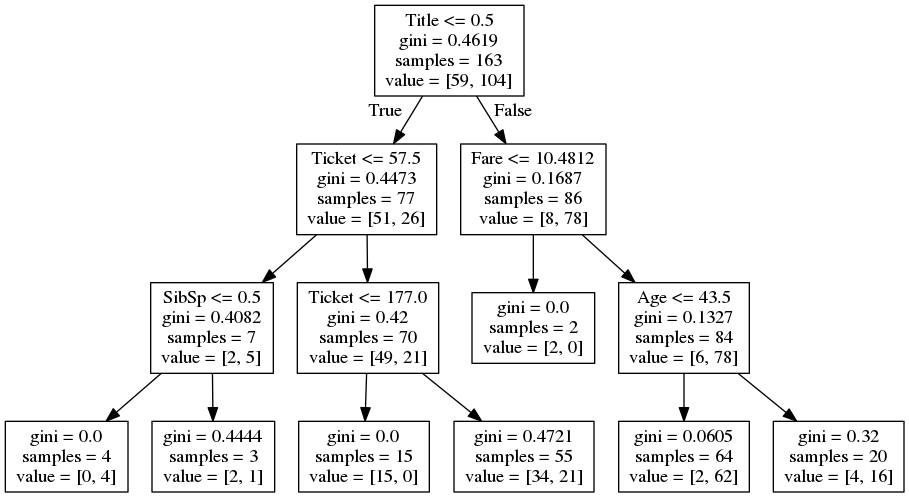

In [23]:
# Calling and drawing a precision tree with max_depth
# Note that this call removes all the nan (large part of the dataset) and just displays a decision tree for illustration
foo = trainPredictAndAnalyzeDecisionTree(myInDf.dropna(), aDepth=3, draw=True)

In [24]:
# Do not use features which have any value missing
myCompleteFeatures = [x for x in myInDf.columns if myInDf.isnull().sum()[x] ==0]
myCompleteFeatures.append('Survived')
myStats = runMonteCarlo(myInDf[myCompleteFeatures].dropna(), trainPredictAndAnalyzeDecisionTree).describe() # capture for later
myStats

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.689049,0.690920,0.688122
std,0.0,0.0,0.0,0.061491,0.062419,0.050817
min,1.0,1.0,1.0,0.531646,0.553846,0.586466
25%,1.0,1.0,1.0,0.653646,0.648566,0.648951
50%,1.0,1.0,1.0,0.684950,0.692810,0.694232
75%,1.0,1.0,1.0,0.738650,0.736111,0.726936
max,1.0,1.0,1.0,0.815385,0.797101,0.779412


# Using random forests

Random forests can be used in this dataset to boost performance and lower the variance (overfitting) of the classification.

In [25]:
from sklearn.ensemble import RandomForestClassifier

def trainPredictAndAnalyzeRandomForest (aDf, *args):
    if len(args)>0:
        myNfeat = args[0]
    else:
        myNfeat = 'auto'
    # Build a decision tree classifier
    myXtrain, myYtrain, myXval, myYval = splitDataset (aDf, train_size)
    myClf = RandomForestClassifier(max_features=myNfeat)
    myClf = myClf.fit(myXtrain, myYtrain)
    aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain, myClf)  
    aValPrecision, aValRecall, aValF1 = assessPerformance(myXval, myYval, myClf)
    return aTrainPrecision, aTrainRecall, aTrainF1, aValPrecision, aValRecall, aValF1

runMonteCarlo(myInDf[myCompleteFeatures].dropna(), trainPredictAndAnalyzeRandomForest).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.994336,0.961128,0.977415,0.795430,0.680868,0.731252
std,0.004131,0.011307,0.006301,0.051625,0.064793,0.042783
min,0.984556,0.940299,0.965517,0.684932,0.548387,0.629630
25%,0.992424,0.954511,0.973101,0.755843,0.632414,0.698799
50%,0.996132,0.958877,0.977442,0.797086,0.692810,0.733041
75%,0.996313,0.967480,0.981000,0.827825,0.717634,0.763359
max,1.000000,0.985714,0.991023,0.890909,0.819672,0.802817


Looking at these results it looks like we can get some better results by analyzing the cross-validation sets. Let's play with the number of features used in the random forest to see if we can boost performance

In [26]:
# Create a MultiIndex dataframe to store the stats of all the different runs
myNfeat = np.arange(2,11)
myIndex = pd.MultiIndex.from_product([myNfeat, myStats.columns])
myDf = pd.DataFrame(index=myIndex, columns=myStats.index)
for myN in myNfeat:
    myDf.loc[myN,:].iloc[:] = runMonteCarlo(myInDf[myCompleteFeatures].dropna(), trainPredictAndAnalyzeRandomForest, myN).describe().iloc[:].transpose()

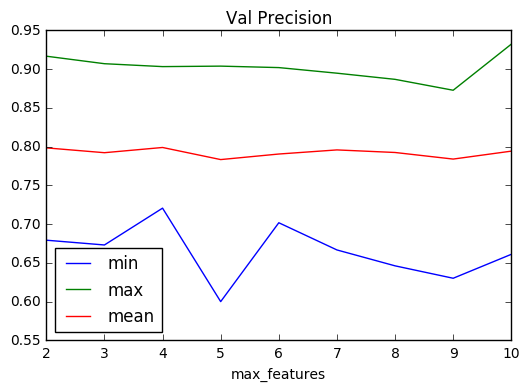

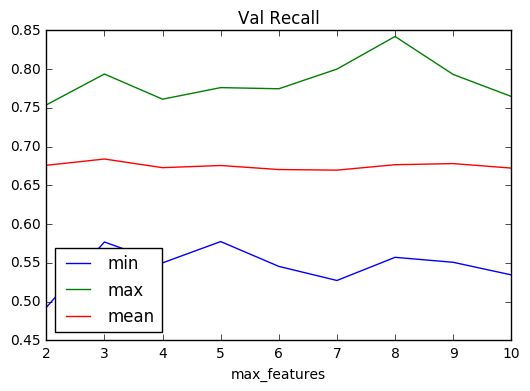

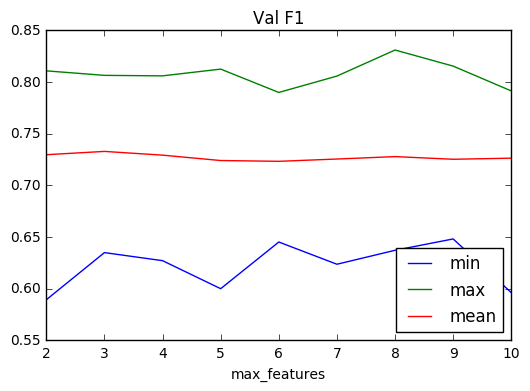

In [27]:
for i in ['Val Precision', 'Val Recall', 'Val F1']:
    myDf.reset_index().set_index('level_1').loc[i][['level_0', 'min', 'max', 'mean']].set_index('level_0').plot()
    plt.title(i)
    plt.xlabel('max_features')
plt.show()

Seems that max_features does not have a huge effect and the data is not overfit. Let's assume the default value of sklearn (sqrt(num_features))

# Using the full dataset and finding a solution
Now we will use the full training dataset for training (no cross-validation) and we will train a random forest classifier

In [28]:
# Train the classifier
myUsedFeatures = [x for x in myCompleteFeatures if x != 'Survived']
myXtrain = myInDf[myCompleteFeatures].dropna()[myUsedFeatures]
myYtrain = myInDf['Survived'].dropna()
myClf = RandomForestClassifier()
myClf = myClf.fit(myXtrain, myYtrain)
aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain, myClf)  

print 'Precision on full training set ' + str(aTrainPrecision)
print 'Recall on full training set ' + str(aTrainRecall)
print 'F1 on full training set ' + str(aTrainF1)

Precision on full training set 0.987915407855
Recall on full training set 0.956140350877
F1 on full training set 0.97176820208


In [36]:
# Run the prediction on the test set
myXtest = myInDf.loc[myInDf['Survived'].isnull(), myUsedFeatures]
myOut = pd.Series(myClf.predict(myXtest), index=myXtest.index)
myOut = myOut.apply(np.int)
myOut.to_csv('solution.csv', header=['Survived'])

In [37]:
myOut.head(5)

PassengerId
892    0
893    0
894    0
895    0
896    0
dtype: int64